In [33]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

## Gaussian Process Regression

A data set $\mathcal{D}= \left (\mathbf{x}, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

The assumption is that the actual observations are a noise-corrupted value of the true model:
$$
y = f(x) + \varepsilon, \tag{1}
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise. FOr example, the model could be $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$.  

In general, the posterior predictive distribution is:

$$ p(y \mid x, \mathcal{D}) = \int p(y, w \mid x, \mathcal{D}) d w = \int p(y \mid x, w) p(w \mid \mathcal{D}) dw \tag{2}$$

Using Eq. (1), one can write the likelihood, which is Gaussian

$$p(y \mid w) = p(y \mid x, w) = \mathcal{N}(y; f(x), \sigma^2)$$

However, the integral in Eq. (1) is intractable in closed form. The trick is realizing that the first term in Eq. (1) is a Gaussian. Furthermore, $p(w \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid w) p(w)}{Z}$ is a product of Gaussians normalized by a Gaussian, so it is also a Gaussian, therefore, $p(y \mid x, \mathcal{D}) $ is a Gaussian.


$p(\mathbf{y}\mid\mathbf{x})$ is thus fully specified by the Kernel, and it starts out being the Gaussian process prior
$$ p(y_1, ... y_n \mid x_1, .., x_n)  = \mathcal{N}(y;0, \Sigma) \tag{3}$$ 
Where, $\Sigma$ can be decomposed as

$$ \Sigma =  \begin{pmatrix}
k & k_* \\
k_*^T & k_{**}
\end{pmatrix} $$

Another way to write Eq. (3) is
$$ \left[\begin{array}{c}
f\left(x^*\right) \\
f\left(x_1\right) \\
\vdots \\
f\left(x_n\right)
\end{array}\right] \sim N\left(\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0
\end{array}\right],\left[\begin{array}{cc}
k\left(x^*, x^*\right) & k\left(x^*, \mathbf{x}\right)^T \\
k\left(x^*, \mathbf{x}\right) & K_{\mathbf{x x}}
\end{array}\right]\right)$$


where the the kernel components $k$'s are functions of $x_1,...,x_n$ and $x_*$
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$

The most commonly used kernel is the RBF kernel  $\Sigma_{x,y} = k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  There is usually a multiplicative constant in front which controls the amplitude, and can be accessed with `ScaleKernel(RBFKernel())`

Now, given a new data point $x^*$, $y^*$ can be predicted with
$$
y_* | \mathcal{D}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)), \tag{4}
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$

$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$



In [129]:
def branin(x, y):
    a = 1
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1-t)*np.cos(x) + s

def objective_function(x):
    # Objective function with a non-differentiable point at x = 0
    return torch.abs(x - 2)  # Shifted to have a minimum at x = 2


The `GPModel` class is the thing that calculates the Gaussian process. If you pass it the training set, it calculates the prior distribution. If you pass it some new points, it calculates the conditional distribution given by n
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$

In [130]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

## train on training set

In [399]:
BRANIN=False
if BRANIN:
    train_x = torch.rand(5,2,dtype=torch.float64)
    def calc_output(train_x):
        return torch.tensor([branin(x[0], x[1]) for x in train_x],dtype=torch.float64).unsqueeze(-1)
    train_y = calc_output(train_x).reshape(-1)
else:

    train_x = torch.linspace(-5, 5, 5,dtype=torch.float64)
    train_y = objective_function(train_x)
    print(train_y)
    


tensor([7.0000, 4.5000, 2.0000, 0.5000, 3.0000], dtype=torch.float64)


## Define model and likelihood

A likelihood here is a mapping from the latent function values $f(\mathbf{x})$ to the observed labels $y$, namely $p(y \mid f(\mathbf{x}))$. For example $p(y \mid f(\mathbf{x})) = f + \varepsilon$

In [441]:
# GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

In [442]:
model.likelihood.noise.item()

0.6932471990585327

In [443]:
model.train_inputs

(tensor([[-5.0000],
         [-2.5000],
         [ 0.0000],
         [ 2.5000],
         [ 5.0000]], dtype=torch.float64),)

In [444]:
model.train_inputs[0].numpy().ndim

2

In [404]:
model.train_inputs[0].numpy().shape

(5, 1)

In [405]:
model.train_targets

tensor([7.0000, 4.5000, 2.0000, 0.5000, 3.0000], dtype=torch.float64)

In [406]:
def plot_model(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        x_star = torch.tensor(np.random.rand(train_x.shape[0],train_x.shape[1]),)
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()

    
    plt.plot(x_star.numpy(), pred, label='Mean Prediction')
    plt.fill_between(x_star.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x, train_y, 'k*', label='Observed Data')
    plt.legend()
    plt.show()

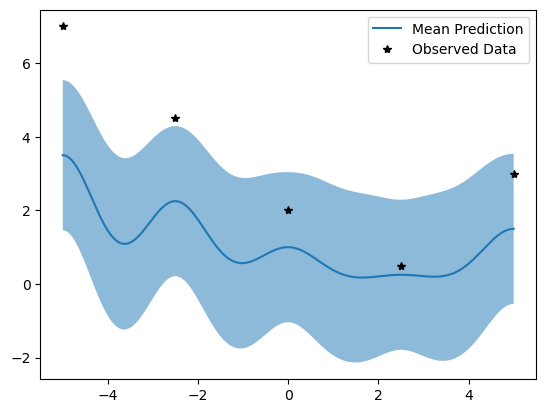

In [407]:
plot_model(model)

In [408]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [409]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.])
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf)
mean_module.raw_constant tensor(0.)
covar_module.raw_outputscale tensor(0.)
covar_module.base_kernel.raw_lengthscale tensor([[0.]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf)


## Train GP model

In [449]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
                print('Epoch %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
        loss.backward()
        optimizer.step()

In [450]:
train_model(model, train_x, train_y, 50,print_=True)

Epoch 1/50 - Loss: 7.028   lengthscale: 0.693   noise: 0.693
Epoch 2/50 - Loss: 6.424   lengthscale: 0.744   noise: 0.744
Epoch 3/50 - Loss: 5.893   lengthscale: 0.797   noise: 0.798
Epoch 4/50 - Loss: 5.425   lengthscale: 0.851   noise: 0.853
Epoch 5/50 - Loss: 5.013   lengthscale: 0.907   noise: 0.910
Epoch 6/50 - Loss: 4.652   lengthscale: 0.966   noise: 0.967
Epoch 7/50 - Loss: 4.334   lengthscale: 1.028   noise: 1.026
Epoch 8/50 - Loss: 4.056   lengthscale: 1.092   noise: 1.084
Epoch 9/50 - Loss: 3.813   lengthscale: 1.160   noise: 1.142
Epoch 10/50 - Loss: 3.601   lengthscale: 1.231   noise: 1.200
Epoch 11/50 - Loss: 3.416   lengthscale: 1.305   noise: 1.257
Epoch 12/50 - Loss: 3.257   lengthscale: 1.381   noise: 1.312
Epoch 13/50 - Loss: 3.119   lengthscale: 1.459   noise: 1.366
Epoch 14/50 - Loss: 3.000   lengthscale: 1.538   noise: 1.418
Epoch 15/50 - Loss: 2.898   lengthscale: 1.618   noise: 1.468
Epoch 16/50 - Loss: 2.809   lengthscale: 1.698   noise: 1.516
Epoch 17/50 - Los

In [451]:
model.likelihood.noise.item()

2.1738152503967285

## observe that the GP model and likelihood parameters have been optimized

In [452]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([2.0530])
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf)
mean_module.raw_constant tensor(2.8189)
covar_module.raw_outputscale tensor(2.3031)
covar_module.base_kernel.raw_lengthscale tensor([[2.8836]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf)


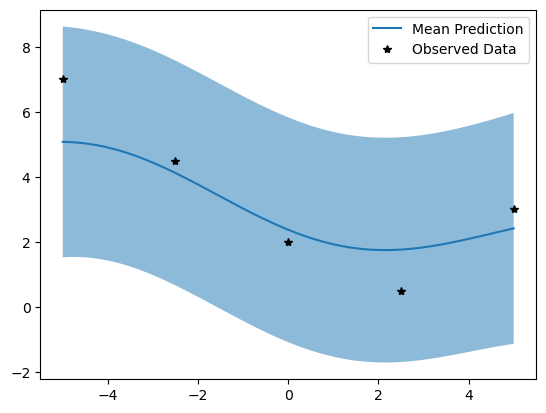

In [453]:
plot_model(model)

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [454]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
    return ei


## Bayesian Optimization Algorithm
1. Construct a regression model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function
$$
x_{new} = \arg\max\limits_x a(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

In [465]:
def BayesOpt(model, train_x, train_y, n_epochs, retrain_gp=False,print_=False):
    # Use the Adam optimizer

    model.eval()
    likelihood.eval()
    for epoch in range(n_epochs):

        x_candidates = torch.linspace(-5,5,100)
        ei = expected_improvement(model, train_y, x_candidates)
        ei_argmax = ei.argmax()
        next_x = x_candidates[ei_argmax]
        next_y = objective_function(next_x)
        train_x = torch.cat([train_x, next_x.unsqueeze(-1)])
        next_y = torch.tensor([next_y])

        print(f'epoch {epoch} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # retrain model with updated data
        if retrain_gp:
            model.train()
            train_model(model, train_x, train_y, n_epochs, print_=print_)
        
        
        

## perform Bayesian optimization without retraing model with the updated data

In [466]:
BayesOpt(model, train_x, train_y, 25)

epoch 0 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 1 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 2 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 3 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 4 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 5 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 6 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 7 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 8 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 9 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 10 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 11 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 12 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 13 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 14 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 15 next_x = 2.1717171669006348, next_y = ten

In [467]:
train_x.shape

torch.Size([5])

In [468]:
model.train_inputs[0].numpy().shape

(30, 1)

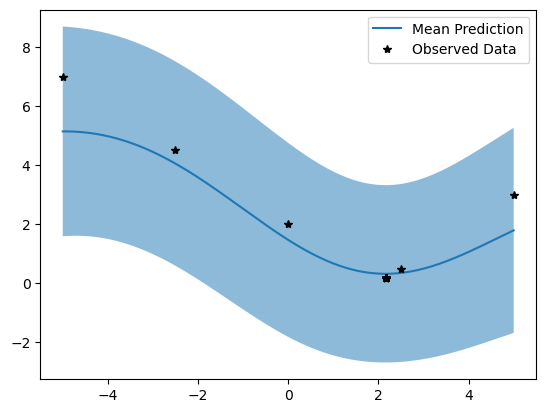

In [469]:
plot_model(model)

In [470]:
def get_best_parameter(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    best_param_observed_param = train_x[train_y.argmin()]
    print(f'best parameter = {best_param_observed_param}')
    return best_param_observed_param

In [471]:
get_best_parameter(model)

best parameter = [2.17171717]


array([2.17171717])

## Perform Bayeian Optimization with retraing model with the updated data

In [472]:
BayesOpt(model, train_x, train_y, 25, retrain_gp=True,print_=False)

epoch 0 next_x = 2.1717171669006348, next_y = tensor([0.1717])
epoch 1 next_x = 1.9696969985961914, next_y = tensor([0.0303])
epoch 2 next_x = 1.8686869144439697, next_y = tensor([0.1313])
epoch 3 next_x = 1.767676830291748, next_y = tensor([0.2323])
epoch 4 next_x = 1.767676830291748, next_y = tensor([0.2323])
epoch 5 next_x = 1.8686869144439697, next_y = tensor([0.1313])
epoch 6 next_x = 1.8686869144439697, next_y = tensor([0.1313])
epoch 7 next_x = 1.8686869144439697, next_y = tensor([0.1313])
epoch 8 next_x = 3.7878787517547607, next_y = tensor([1.7879])
epoch 9 next_x = -0.9595960378646851, next_y = tensor([2.9596])
epoch 10 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 11 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 12 next_x = -3.5858585834503174, next_y = tensor([5.5859])
epoch 13 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 14 next_x = 2.070707082748413, next_y = tensor([0.0707])
epoch 15 next_x = 1.9696969985961914, next_y = tensor(

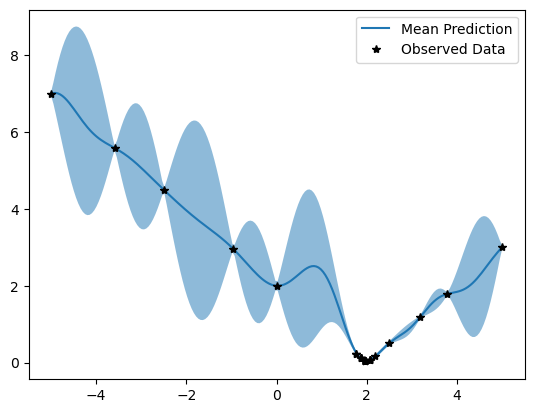

In [473]:
plot_model(model)

In [476]:
get_best_parameter(model)

best parameter = [1.969697]


array([1.969697])

In [477]:
model.train_inputs

(tensor([[-5.0000],
         [-2.5000],
         [ 0.0000],
         [ 2.5000],
         [ 5.0000],
         [ 2.1717],
         [ 1.9697],
         [ 1.8687],
         [ 1.7677],
         [ 1.7677],
         [ 1.8687],
         [ 1.8687],
         [ 1.8687],
         [ 3.7879],
         [-0.9596],
         [ 2.0707],
         [ 2.0707],
         [-3.5859],
         [ 2.0707],
         [ 2.0707],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697],
         [ 3.1818],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697],
         [ 1.9697]], dtype=torch.float64),)

## save model


In [52]:
path = 'models/test_GP.pth'
torch.save(model.state_dict(), path)

## Refresh the kernel (as if opening a new notebook) and load model

In [53]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

In [54]:
def branin(x, y):
    a = 1
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1-t)*np.cos(x) + s

def objective_function(x):
    # Objective function with a non-differentiable point at x = 0
    return torch.abs(x - 2)  # Shifted to have a minimum at x = 2


In [55]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

In [56]:
BRANIN=False
if BRANIN:
    train_x = torch.rand(5,2)
    def calc_output(train_x):
        return torch.tensor([branin(x[0], x[1]) for x in train_x]).unsqueeze(-1)
    train_y = calc_output(train_x)
else:

    train_x = torch.linspace(-5, 5, 50)#.unsqueeze(-1)
    train_y = objective_function(train_x)#.unsqueeze(-1)
    print(train_y)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)
path = 'models/test_GP.pth'
model.load_state_dict(torch.load(path))
model.eval()

tensor([7.0000, 6.7959, 6.5918, 6.3878, 6.1837, 5.9796, 5.7755, 5.5714, 5.3673,
        5.1633, 4.9592, 4.7551, 4.5510, 4.3469, 4.1429, 3.9388, 3.7347, 3.5306,
        3.3265, 3.1224, 2.9184, 2.7143, 2.5102, 2.3061, 2.1020, 1.8980, 1.6939,
        1.4898, 1.2857, 1.0816, 0.8776, 0.6735, 0.4694, 0.2653, 0.0612, 0.1429,
        0.3469, 0.5510, 0.7551, 0.9592, 1.1633, 1.3673, 1.5714, 1.7755, 1.9796,
        2.1837, 2.3878, 2.5918, 2.7959, 3.0000])


GPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [57]:
model.train_inputs

(tensor([[-5.0000],
         [-4.7959],
         [-4.5918],
         [-4.3878],
         [-4.1837],
         [-3.9796],
         [-3.7755],
         [-3.5714],
         [-3.3673],
         [-3.1633],
         [-2.9592],
         [-2.7551],
         [-2.5510],
         [-2.3469],
         [-2.1429],
         [-1.9388],
         [-1.7347],
         [-1.5306],
         [-1.3265],
         [-1.1224],
         [-0.9184],
         [-0.7143],
         [-0.5102],
         [-0.3061],
         [-0.1020],
         [ 0.1020],
         [ 0.3061],
         [ 0.5102],
         [ 0.7143],
         [ 0.9184],
         [ 1.1224],
         [ 1.3265],
         [ 1.5306],
         [ 1.7347],
         [ 1.9388],
         [ 2.1429],
         [ 2.3469],
         [ 2.5510],
         [ 2.7551],
         [ 2.9592],
         [ 3.1633],
         [ 3.3673],
         [ 3.5714],
         [ 3.7755],
         [ 3.9796],
         [ 4.1837],
         [ 4.3878],
         [ 4.5918],
         [ 4.7959],
         [ 5.0000]])

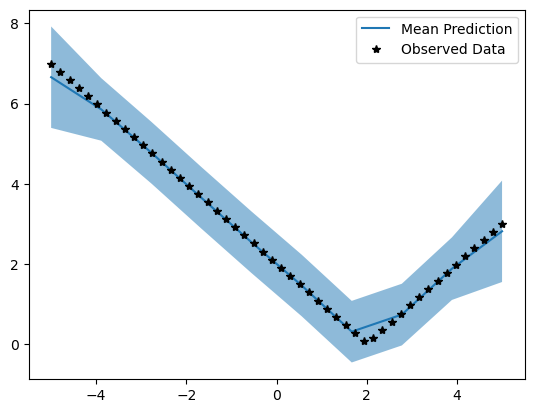

In [58]:
x = torch.linspace(-5, 5, 10)
with torch.no_grad():
    pred = model(x.unsqueeze(-1))
    lower, upper = pred.confidence_region()

plt.plot(x.numpy(), pred.mean.numpy(), label='Mean Prediction')
plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed Data')
plt.legend()
plt.show()

In [59]:
pred_mean = pred.mean.numpy()
param = x.numpy()
best_x = param[pred_mean.argmin()]
print(f'minimum of mean value function = {best_x}')
observed_min = train_x[train_y.argmin()]
print(f'observed minimum in data = {observed_min}')

minimum of mean value function = 1.6666665077209473
observed minimum in data = 1.9387754201889038
